In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from urllib.request import urlopen
import json
from credentials import *
from entsoe import EntsoePandasClient
from entsoe.mappings import lookup_area
from pycaret.time_series import *
import logging

mpl.rcParams['figure.dpi'] = 150
logging.disable(logging.CRITICAL)


### Loading Dataset

In [25]:
# Get energy data from ENTSO-E API
country_code = 'GR'
area = lookup_area(country_code)

client = EntsoePandasClient(api_key=get_token())
end = pd.Timestamp.now(tz=area.tz) # - pd.DateOffset(days=10)
start = end - pd.DateOffset(weeks = 2)
%time df_energy = client.query_generation(area, start=start,end=end, nett = True, psr_type=None)
df_energy.set_index(df_energy.index.tz_convert(None), inplace = True)
df_energy = df_energy.resample('H').mean()
df_energy.tail()

Wall time: 2.89 s


,Fossil Brown coal/Lignite,Fossil Gas,Fossil Oil,Hydro Pumped Storage,Hydro Water Reservoir,Solar,Wind Onshore
2022-07-10 20:00:00,720.0,3370.0,0.0,224.0,815.0,0.0,370.0
2022-07-10 21:00:00,728.0,3301.0,0.0,159.0,608.0,0.0,392.0
2022-07-10 22:00:00,733.0,3431.0,0.0,1.0,191.0,0.0,448.0
2022-07-10 23:00:00,NaN,NaN,NaN,NaN,NaN,0.0,456.0
2022-07-11 00:00:00,NaN,NaN,NaN,NaN,NaN,0.0,504.0


### Forecasting with PyCaret

In [26]:
ts = setup(data = df_energy['Solar'], fh = 48,
           enforce_exogenous = False, fold = 3)
           

,Description,Value
0,session_id,6117
1,Target,Solar
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(334, 1)"
5,Transformed data shape,"(334, 1)"
6,Transformed train set shape,"(286, 1)"
7,Transformed test set shape,"(48, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [34]:
model = create_model('auto_arima', cross_validation = False, engine = 'statsforecast')

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,3.8545,2.7525,180.3826,321.5814,0.1698,0.1497,0.8602


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

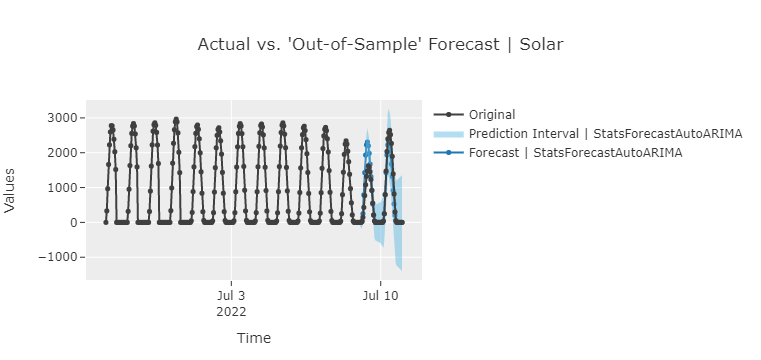

In [ ]:
fig_kwargs = {'renderer': 'jupyterlab'}

plot_model(model, 'forecast', fig_kwargs = fig_kwargs)

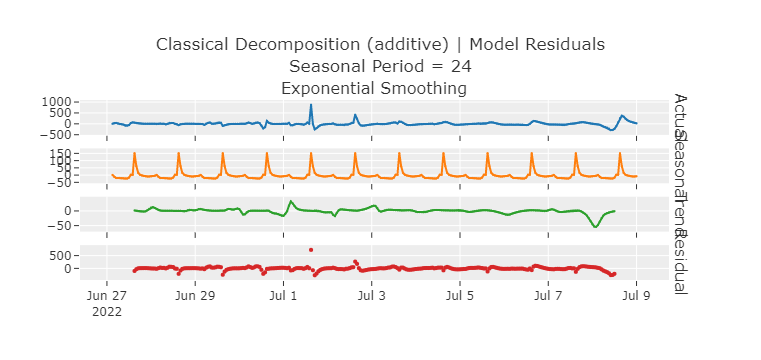

In [29]:
plot_model(model, 'decomp', fig_kwargs = fig_kwargs)